In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import UnivariateSpline
from typing import Optional, Tuple

In [10]:
def merton_jump_paths(
    S0: float,
    T: float,
    alpha: float, 
    sigma: float, 
    lam: float, 
    m: float, 
    v: float, 
    N: int, 
    seed: Optional[int] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a single stock price path using Merton's Jump Diffusion Model with normally distributed jump log returns.

    Args:
    - S0 (float): Initial stock price
    - T (float): Data simulated on [0, T]
    - alpha (float): Drift
    - sigma (float): Volatility
    - lam (float): Jump intensity (expected number of jumps per unit time)
    - m (float): Mean of jump log return
    - v (float): Standard deviation of jump log return
    - N (int): Number of time steps (subdivisions of [0, T])
    - seed (Optional[int]): Seed for reproducibility.

    Returns:
    - t (np.ndarray): Array of time points
    - S (np.ndarray): Array of stock prices for the single path
    """
    if seed is not None:
        np.random.seed(seed=seed)
    
    dt = T / N
    S = np.zeros(N + 1)
    k = np.exp(m + 0.5 * v**2) - 1  # k = expected return of a jump; note the jump *log* returns are assumed Normal(m, v^2)
    
    jump_times = []
    S[0] = S0
    
    for i in range(1, N + 1):
        
        normal_rv = np.random.normal(loc=0, scale=1)
        
        non_jump_factor = np.exp(
            (alpha - 0.5 * sigma**2 - lam * k) * dt + sigma * np.sqrt(dt) * normal_rv
        )
        
        S[i] = S[i - 1] * non_jump_factor
        
        # simulate Poisson jump process :
        n_jumps = np.random.poisson(lam=lam * dt)  # no. of jumps in [t, t+dt] is Poisson(lambda * dt)
        if n_jumps == 0:
            continue
            
        cumulative_jump_log_ret = 0
        for _ in range(n_jumps):
            jump_log_ret = np.random.normal(loc=m, scale=v)  # jump log returns are Normal
            cumulative_jump_log_ret += jump_log_ret
            
        S[i] *= np.exp(cumulative_jump_log_ret)
        jump_times.append(i)

    return S, jump_times

In [11]:
# Parameters
S0 = 5    # Initial stock price
T = 1  # path on [0, T]
alpha = 0.30    # Drift (expected return)
sigma = 0.2 # Volatility
lam = 10     # Jump intensity (expected number of jumps per simulation)
m = 0.0       # Mean of jump log return
v = 0.2     # Standard deviation of jump log return
N = 100     # Number of time steps to simulate
seed = 42   # Seed for reproducibility

# Generate stock price paths
S, jump_times = merton_jump_paths(S0=S0, T=T, alpha=alpha, sigma=sigma, lam=lam, m=m, v=v, N=N, seed=seed)

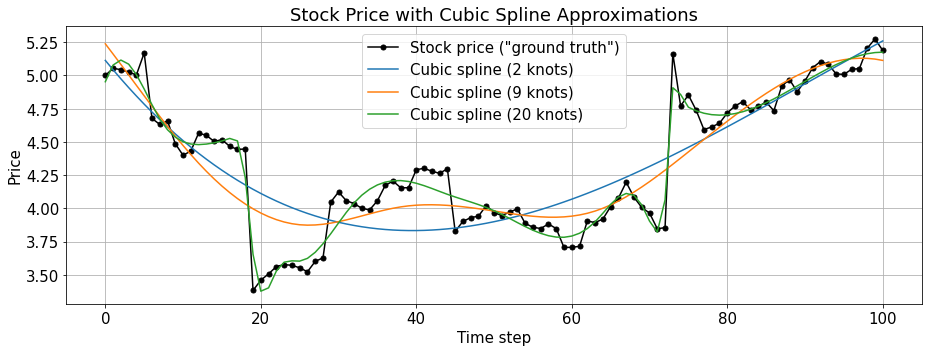

In [12]:
# Plotting
plt.figure(figsize=(13, 5))
time_steps = range(len(S))

# Plot original paths
plt.plot(time_steps, S, alpha=1, label="Stock price (\"ground truth\")", marker=".", ls="-", markersize=10, color="black")

# Fit and plot cubic splines with different smoothing parameters
smoothing_factors = [1, 5, 10]  # bigger smoothing factor --> smoother (fewer knots)

for s in sorted(smoothing_factors, reverse=True):
    spline = UnivariateSpline(x=time_steps, y=S, s=s)
    n_knots = len(spline.get_knots())
    plt.plot(time_steps, spline(time_steps), label=f"Cubic spline ({n_knots} knot{'' if n_knots == 1 else 's'})", ls="-", alpha=1)

# if want to add vertical lines at the jumps:
# for jump_time in jump_times:
#     plt.axvline(x=jump_time, ls=':', color='black')
    
plt.title("Stock Price with Cubic Spline Approximations", fontsize=18)
plt.xlabel("Time step", fontsize=15)
plt.ylabel("Price", fontsize=15)
plt.legend(loc="best", ncol=1, fontsize=15)
plt.tick_params(axis="both", which="major", labelsize=15)
plt.grid(b=True, alpha=1.0, ls="-")
plt.tight_layout()

# Save the plot
plt.savefig("stock_sim_image.pdf", format="pdf", dpi=300, bbox_inches="tight", facecolor="none", edgecolor="black")

plt.show();

